In [369]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from src.cp_hw5 import *
from scipy.stats import entropy
from scipy.ndimage import gaussian_filter
import skimage.color
from matplotlib.colors import LightSource

Initials

(63, 133, 3) 15675 110


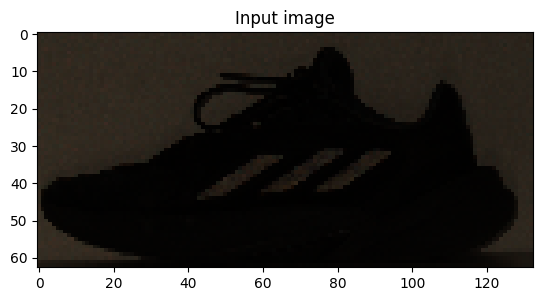

In [467]:
img_bgr = cv2.imread('my_data/bottle/exposure1.tiff', cv2.IMREAD_UNCHANGED)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
x_start = 1480
y_start = 2550
w = 530
h = 1100
img_rgb = img_rgb[x_start:x_start+h, y_start:y_start+w]

img_rgb = img_rgb[::10, ::10]

print(img_rgb.shape, img_rgb.max(), img_rgb.min())
plt.imshow(img_rgb/2**16)
plt.title(f"Input image")  
plt.show()

Doll : 

x_start = 900
y_start = 1820
w = 340
h = 440


Drone :

x_start = 1550
y_start = 2200
w = 2400
h = 580


Cap : 

x_start = 1280
y_start = 2660
w = 1400
h = 800

Shoe : 

x_start = 1980
y_start = 2260
w = 1330
h = 630


Bottle :

x_start = 1480
y_start = 2550
w = 530
h = 1100

(63, 133, 3) 14183 230
(63, 133, 3) 13732 209
(63, 133, 3) 15657 188
(63, 133, 3) 13621 198
(63, 133, 3) 14300 195
(63, 133, 3) 13808 198
(63, 133, 3) 14387 204


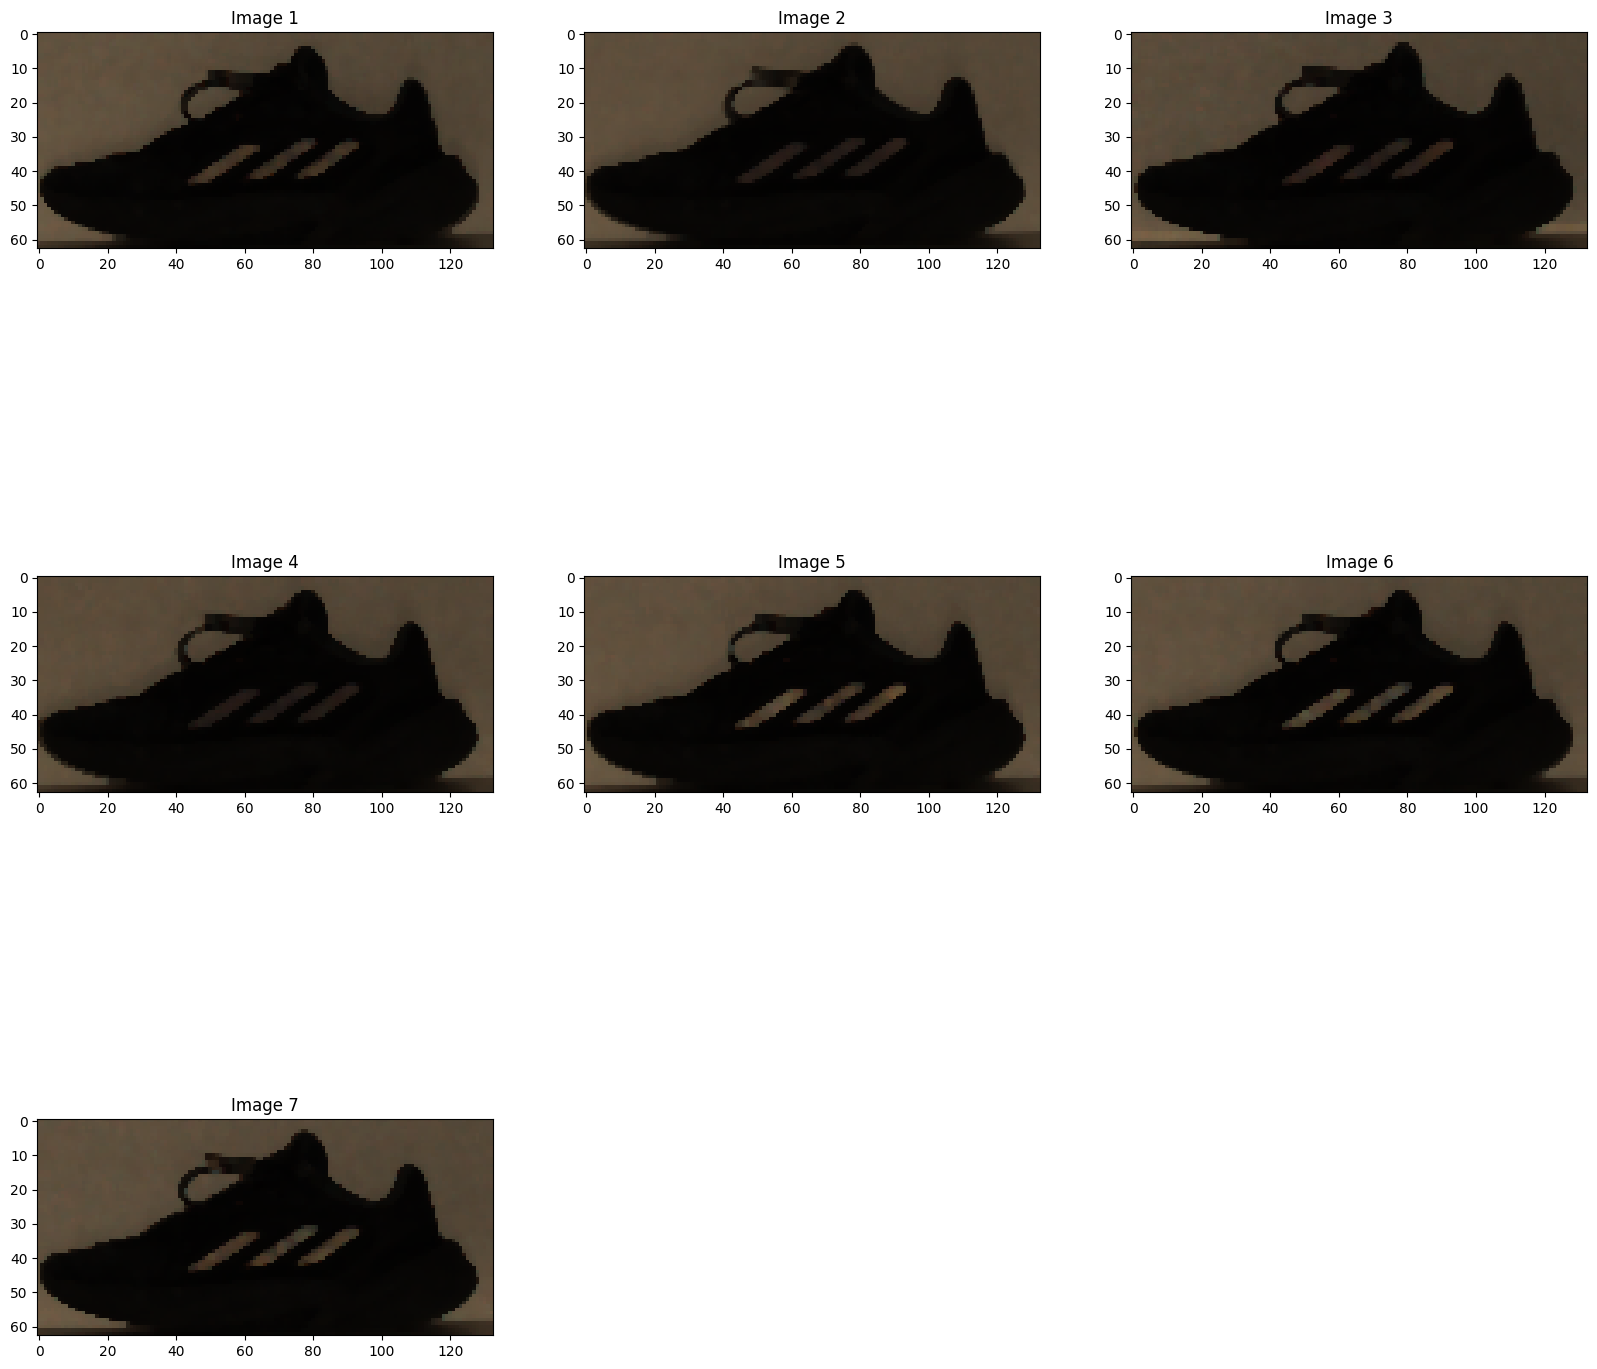

In [481]:
luminance_img_list = []
plt.figure(figsize=(20, 20))
for i in range(1, 8):
    path = 'my_data/bottle/exposure' + str(i) + '.tiff'
    img_bgr = cv2.imread(path, -1)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    x_start = 1480
    y_start = 2550
    w = 530
    h = 1100
    img_rgb = img_rgb[x_start:x_start+h, y_start:y_start+w]

    img_rgb = img_rgb[::10, ::10]
    img_rgb = cv2.medianBlur(img_rgb, 3)
    
    print(img_rgb.shape, img_rgb.max(), img_rgb.min())
    plt.subplot(3, 3, i)  
    plt.imshow(img_rgb/2**15)
    plt.title(f"Image {i}")  

    img_xyz = skimage.color.rgb2xyz(img_rgb)
    img_y = img_xyz[:, :, 1].reshape((img_xyz.shape[0] * img_xyz.shape[1]))
    luminance_img_list.append(img_y)

plt.show()

I = np.array(luminance_img_list)
img_shape = img_xyz.shape

Uncalibrated Photometric Stereo

In [482]:
# Estimating Le and Be

def compute_pseudonormal_matrices(I):
    U, S, Vt = np.linalg.svd(I, full_matrices = False)
    S[3:] = 0
    I = U @ np.diag(S) @ Vt
    U_prime = U @ np.sqrt(np.diag(S))
    Vt_prime = np.sqrt(np.diag(S)) @ Vt
    Le = U_prime[:3]
    Be = Vt_prime[:3]
    return Le, Be

In [483]:
# Compute albedo normals

def compute_albedo_normals(Be):
    Ae = np.linalg.norm(Be, axis = 0)
    Ne = Be / (Ae + 1e-10)
    return Ae, Ne

# Normalize Ae and Ne 

def convert_AeNe_images(Ae, Ne, img_shape):
    Ae = (Ae - np.min(Ae)) / (np.max(Ae) - np.min(Ae))
    Ne = (Ne - np.min(Ne)) / (np.max(Ne) - np.min(Ne))


    # Reshape Ae and Ne to images
    Ae_img = Ae.reshape((img_shape[0], img_shape[1]))
    Ne_img = Ne.T.reshape((img_shape[0], img_shape[1], 3))
    return Ae_img, Ne_img

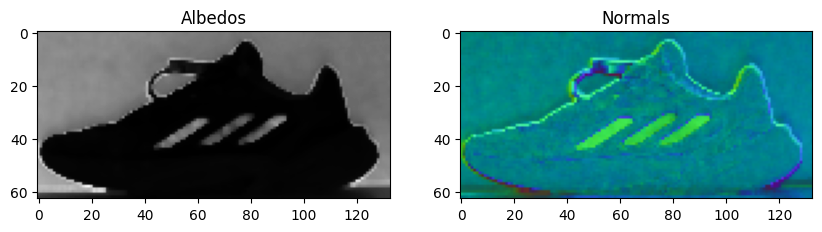

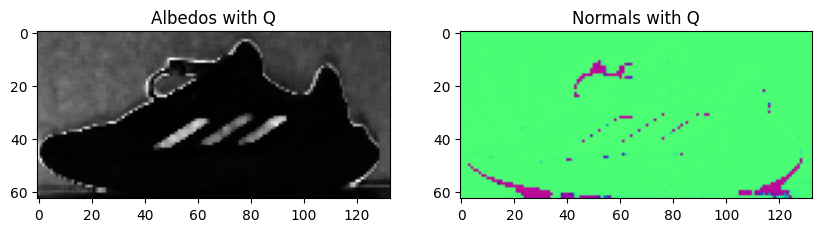

In [484]:
Le, Be = compute_pseudonormal_matrices(I)
Ae, Ne = compute_albedo_normals(Be)
Ae_img, Ne_img = convert_AeNe_images(Ae, Ne, img_shape)

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.title("Albedos")
plt.imshow(Ae_img, cmap="gray")

plt.subplot(122)
plt.title("Normals")
plt.imshow(Ne_img, cmap="rainbow")

# Make sure Q is invertible by considering it as a positive definite matrix
M = np.random.rand(3,3)
epsilon = 1e-12
Q = epsilon * np.eye((3)) + M @ M.T
L_Q = Q @ Le
Q_inv = np.linalg.inv(Q)
B_Q = Q_inv @ Be

Ae_Q, Ne_Q = compute_albedo_normals(B_Q)
Ae_Q_img, Ne_Q_img = convert_AeNe_images(Ae_Q, Ne_Q, img_shape)

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.title("Albedos with Q")
plt.imshow(Ae_Q_img, cmap="gray")

plt.subplot(122)
plt.title("Normals with Q")
plt.imshow(Ne_Q_img, cmap="rainbow")
plt.show()


Enforcing Integrability


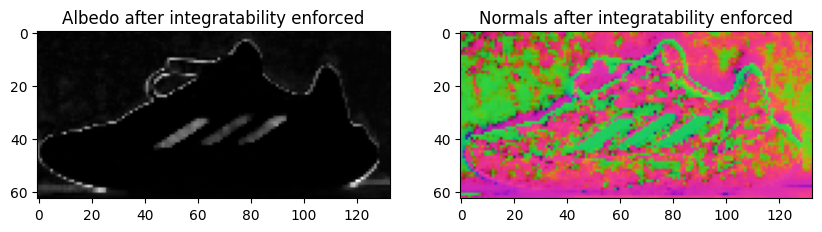

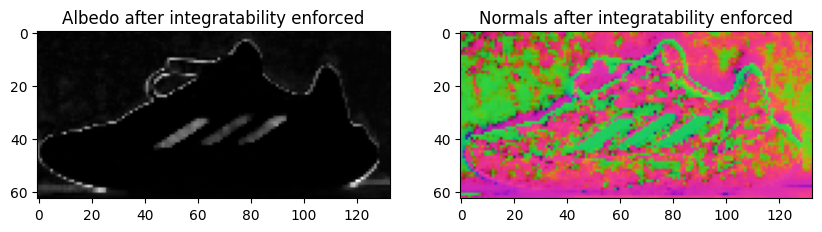

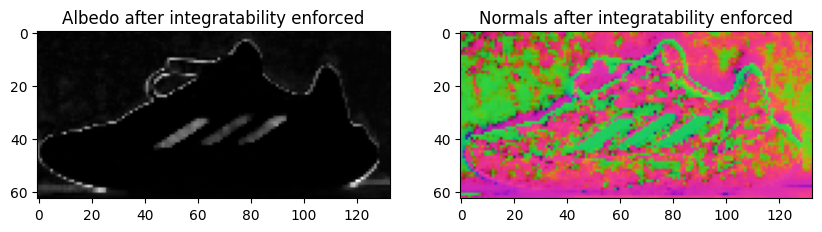

In [485]:
def enforce_integrability(Be, sigma, img_shape):

    be_1 = Be[0, :].reshape(img_shape)
    be_2 = Be[1, :].reshape(img_shape)
    be_3 = Be[2, :].reshape(img_shape)

    be_1_y, be_1_x = np.gradient(gaussian_filter(be_1, sigma), edge_order=2)
    be_2_y, be_2_x = np.gradient(gaussian_filter(be_2, sigma), edge_order=2)
    be_3_y, be_3_x = np.gradient(gaussian_filter(be_3, sigma), edge_order=2)

    A1 = be_1 * be_2_x - be_2 * be_1_x
    A2 = be_1 * be_3_x - be_3 * be_1_x
    A3 = be_2 * be_3_x - be_3 * be_2_x
    A4 = -be_1 * be_2_y + be_2 * be_1_y
    A5 = -be_1 * be_3_y + be_3 * be_1_y
    A6 = -be_2 * be_3_y + be_3 * be_2_y

    A = np.hstack((A1.reshape(-1, 1),
                   A2.reshape(-1, 1),
                   A3.reshape(-1, 1),
                   A4.reshape(-1, 1),
                   A5.reshape(-1, 1),
                   A6.reshape(-1, 1)))
    
    AtA = A.T.dot(A)
    W, V = np.linalg.eig(AtA)
    x = V[:, np.argmin(np.abs(W))]

    delta = np.asarray([[-x[2],  x[5], 1],
                        [ x[1], -x[4], 0],
                        [-x[0],  x[3], 0]])
    Bt = np.linalg.inv(delta) @ Be
    return Bt

for sigma in range(1, 4):
    Be_enforce_int = enforce_integrability(Be, 0.2, img_shape[:2])
    Ae_enforce_int, Ne_enforce_int = compute_albedo_normals(Be_enforce_int)
    Ae_enforce_int_img, Ne_enforce_int_img = convert_AeNe_images(Ae_enforce_int, Ne_enforce_int, img_shape)

    plt.figure(figsize=(10,10))

    plt.subplot(121)
    plt.title('Albedo after integratability enforced')
    plt.imshow(Ae_enforce_int_img, cmap='gray')

    plt.subplot(122)
    plt.title('Normals after integratability enforced')
    plt.imshow(Ne_enforce_int_img, cmap='rainbow')
    plt.show()


#     # Applying GBR inversion transform
# Gf = np.array([[1,0,0],[0,1,0],[0,0,-1]])
# Be_enforce_int = Gf @ Be_enforce_int 
# Ae_enforce_int, Ne_enforce_int = compute_albedo_normals(Be_enforce_int)
# Ae_enforce_int_img, Ne_enforce_int_img = convert_AeNe_images(Ae_enforce_int, Ne_enforce_int, s)

Normal Integration

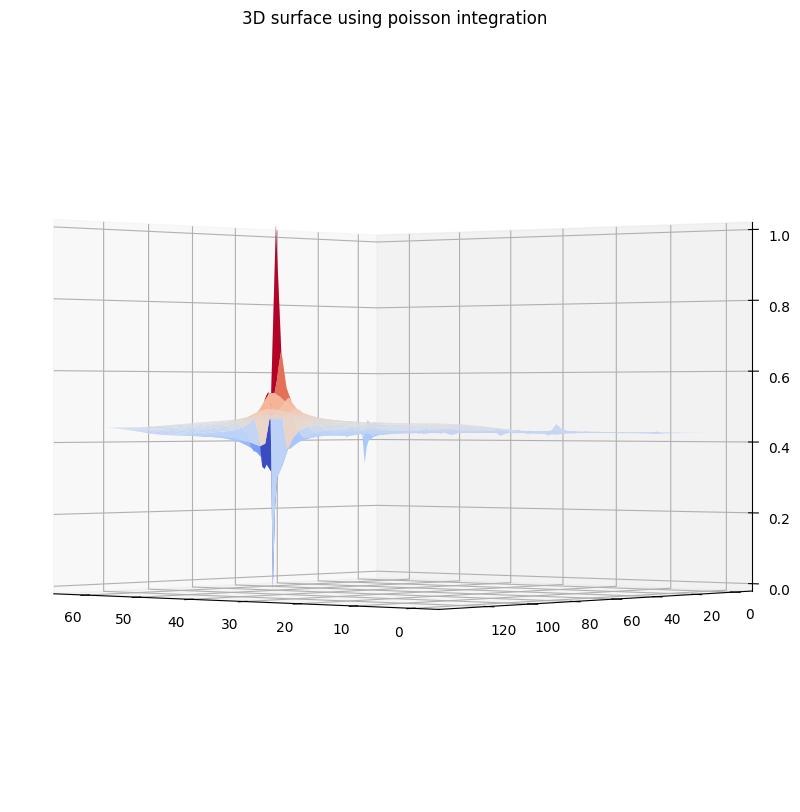

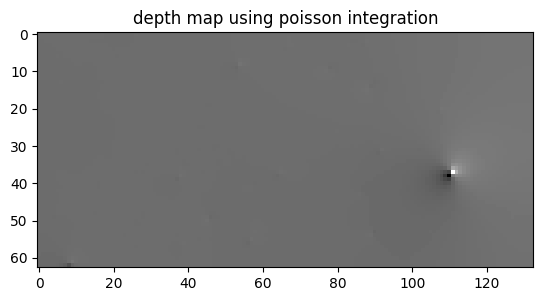

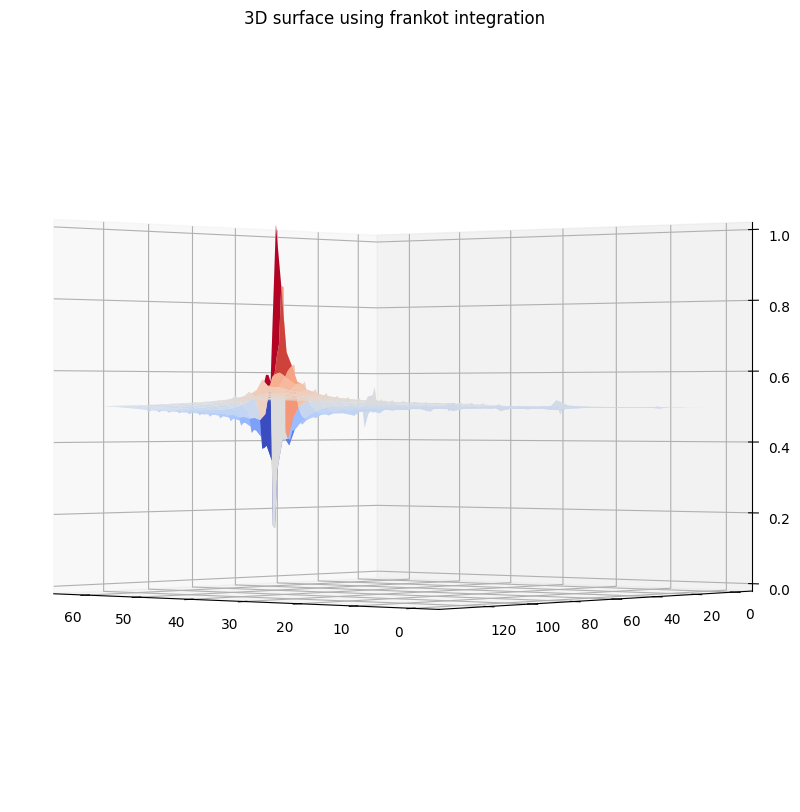

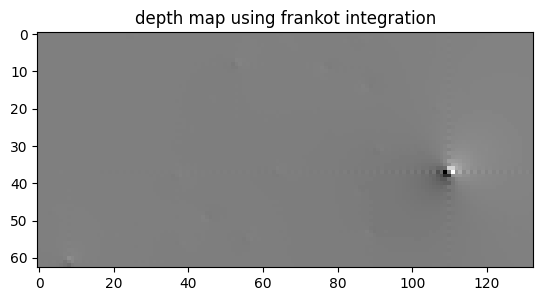

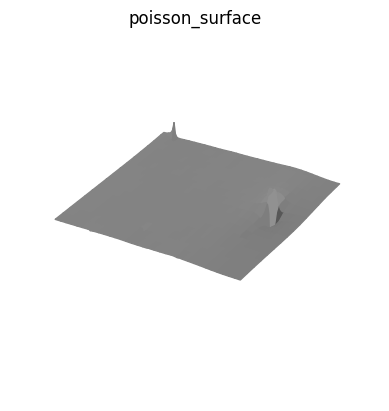

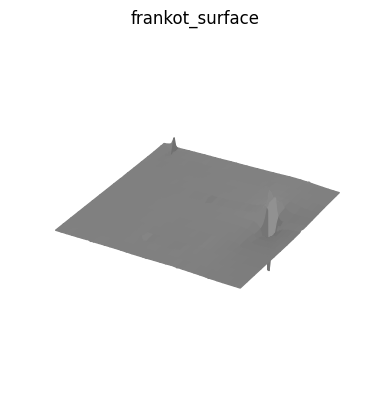

In [486]:



def display_depthmap(surface, title):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    X, Y = np.meshgrid(np.arange(surface.shape[0]), np.arange(surface.shape[1]))
    ax.plot_surface(X.T, Y.T, surface, cmap='coolwarm')
    ax.view_init(elev=0, azim=130)
    plt.title(f"3D surface using {title}")
    plt.show()
    plt.imshow(surface, cmap='gray')
    plt.title(label=f"depth map using {title}")
    plt.show()

def display_surface(Z, title=""):
    # Z is an HxW array of surface depths
    H, W = Z.shape
    x, y = np.meshgrid(np.arange(0,W), np.arange(0,H))
    # set 3D figure
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    # ax.view_init(elev=180, azim=90)
    # ax.view_init(elev=180, azim=180)
    # add a light and shade to the axis for visual effect
    # (use the ‘-’ sign since our Z-axis points down)
    ls = LightSource()
    color_shade = ls.shade(-Z, plt.cm.gray)
    # display a surface
    # (control surface resolution using rstride and cstride)
    surf = ax.plot_surface(x, y, -Z, facecolors=color_shade, rstride=4, cstride=4)
    # turn off axis
    plt.axis("off")
    plt.title(title)
    plt.show()

def normal_integration(Ne, img_shape, integration_type):
    surface = None
    
    f_x = np.reshape(Ne[0, :]/(-Ne[2, :] + 1e-10), img_shape[:2])
    f_y = np.reshape(Ne[1, :]/(-Ne[2, :] + 1e-10), img_shape[:2])
    
    if integration_type == 0 :
        surface = integrate_poisson(f_x, f_y)
        title = 'poisson integration'
    elif integration_type == 1 : 
        surface = integrate_frankot(f_x, f_y)
        title = 'frankot integration'

    surface = (surface - np.min(surface)) / (np.max(surface) - np.min(surface))
    display_depthmap(surface, title)
    return surface

poisson_surface = normal_integration(Ne_enforce_int, img_shape, 0)
frankot_surface = normal_integration(Ne_enforce_int, img_shape, 1)
display_surface(poisson_surface, title="poisson_surface")
display_surface(frankot_surface, title="frankot_surface")



Experimenting with different G 

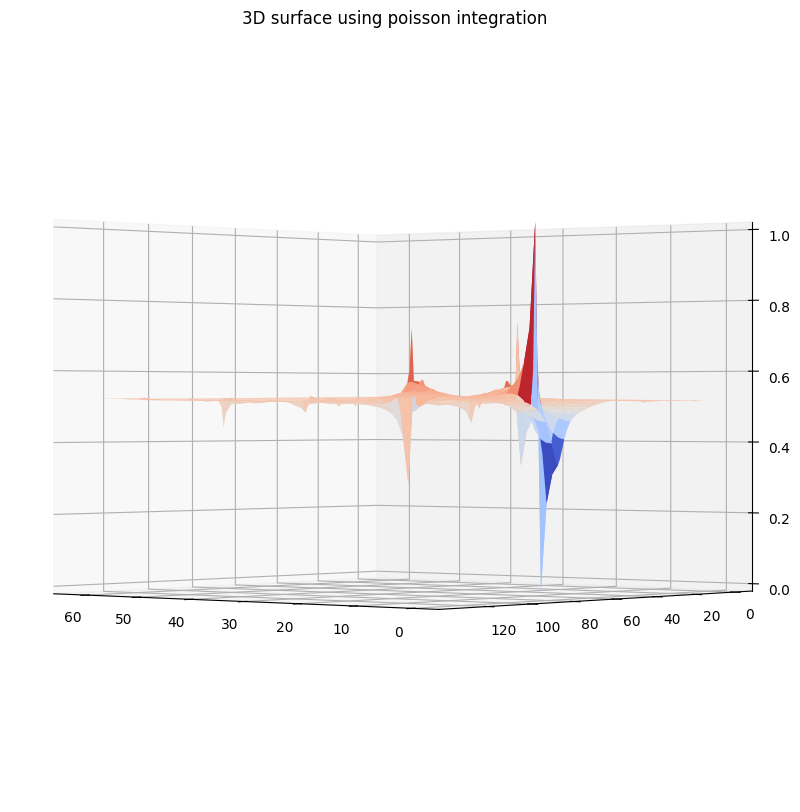

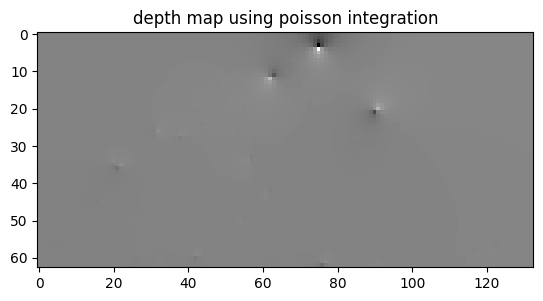

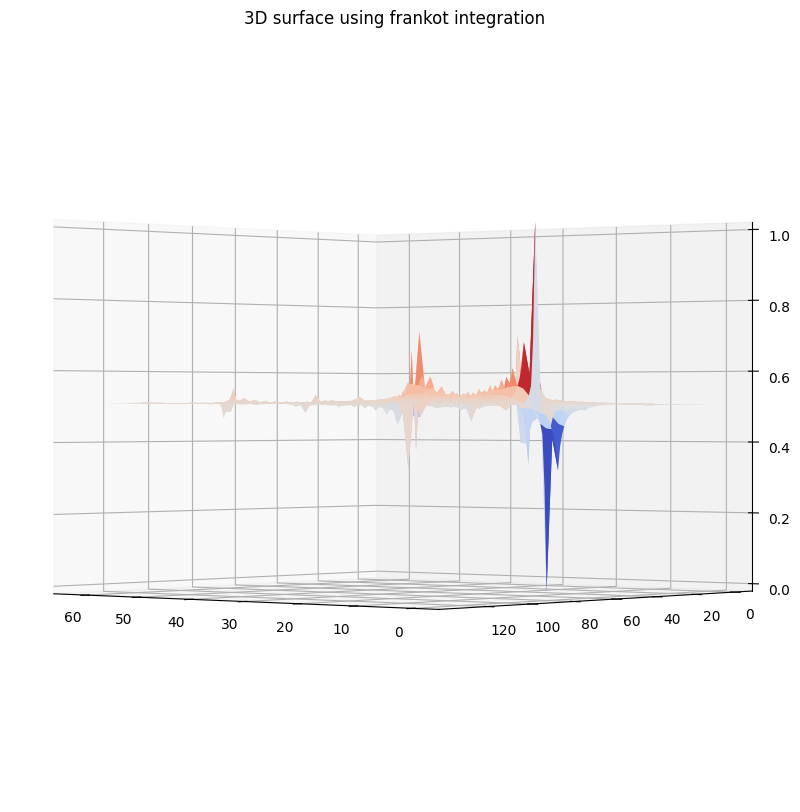

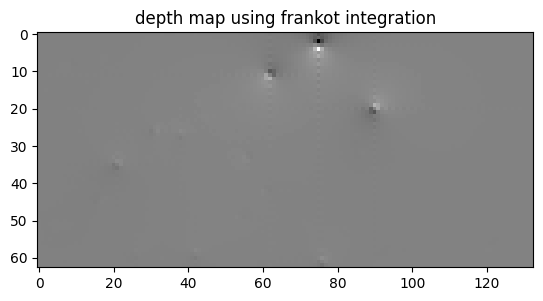

In [487]:
# mu_values = [0, 0.1, -0.1]
# nu_values = [0, 0.1, -0.1]
# lambd_values = [1, 1.2, 0.8]

# for mu in mu_values:
#     for nu in nu_values:
#         for lambd in lambd_values:
mu = 0
nu = 0
lambd = 1

G = np.array([[1, 0, 0], [0, 1, 0], [mu ,nu, lambd]])
Be_updated = G.T @ Be
Be_enforce_int = enforce_integrability(Be_updated, 3, img_shape[:2])
Ae_enforce_int, Ne_enforce_int = compute_albedo_normals(Be_enforce_int)

surface_poisson = normal_integration(Ne_enforce_int, img_shape, 0)
surface_frankot = normal_integration(Ne_enforce_int, img_shape, 1)

Entropy Minimization

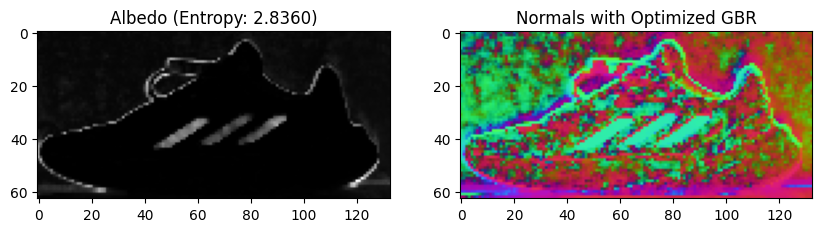

In [488]:
def compute_entropy(albedos):
    hist, _ = np.histogram(albedos, bins=256, range=(0, 1), density=True)
    return entropy(hist)

def optimize_gbr_with_entropy(B_e, num_trials=300):
    best_gbr_matrix = None
    min_entropy = float('inf')

    for _ in range(num_trials):
        mu, nu = np.random.rand(2)
        lambd = np.random.rand() * 10 + 0.1
        gbr_matrix = np.array([[1, 0, 0], [0, 1, 0], [mu, nu, lambd]])
        B_e_transformed = gbr_matrix.T @ B_e  

        albedos = np.linalg.norm(B_e_transformed, axis=0)

        current_entropy = compute_entropy(albedos)

        if current_entropy < min_entropy:
            min_entropy = current_entropy
            best_gbr_matrix = gbr_matrix

    return best_gbr_matrix, min_entropy


Be_integrated = enforce_integrability(Be, sigma=3, img_shape=img_shape[:2])
optimal_gbr, optimal_entropy = optimize_gbr_with_entropy(Be_integrated, num_trials=300)
Be_optimized = optimal_gbr.T @ Be_integrated
Ae_optimized, Ne_optimized = compute_albedo_normals(Be_optimized)
Ae_optimized_img, Ne_optimized_img = convert_AeNe_images(Ae_optimized, Ne_optimized, img_shape)

plt.figure(figsize=(10, 10))

plt.subplot(121)
plt.imshow(Ae_optimized_img, cmap='gray')
plt.title(f'Albedo (Entropy: {optimal_entropy:.4f})')

plt.subplot(122)
plt.imshow(Ne_optimized_img, cmap='rainbow')
plt.title('Normals with Optimized GBR')
plt.show()


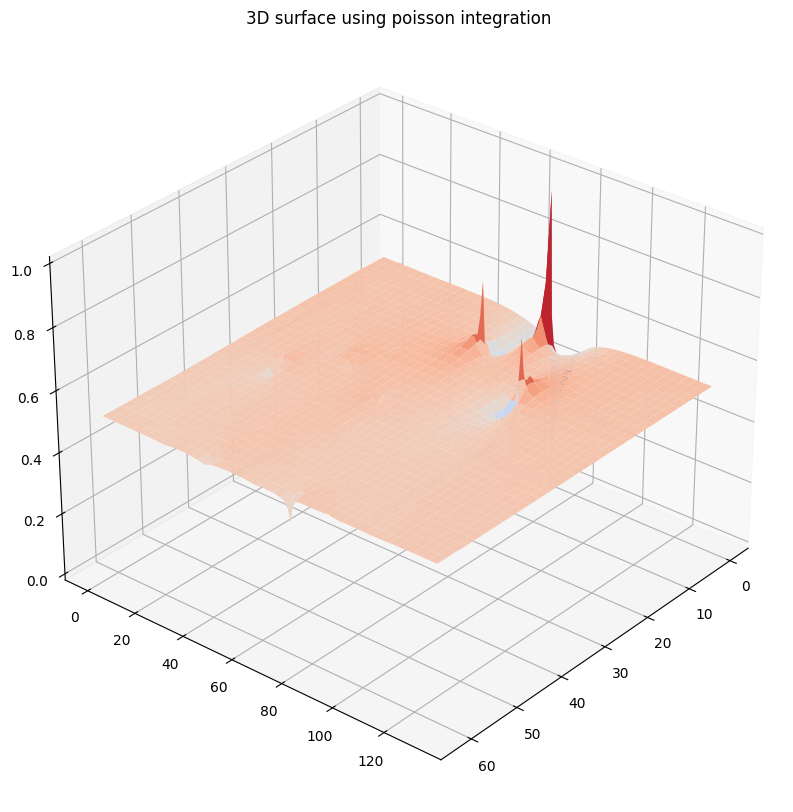

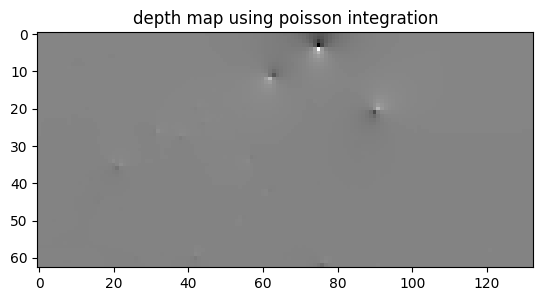

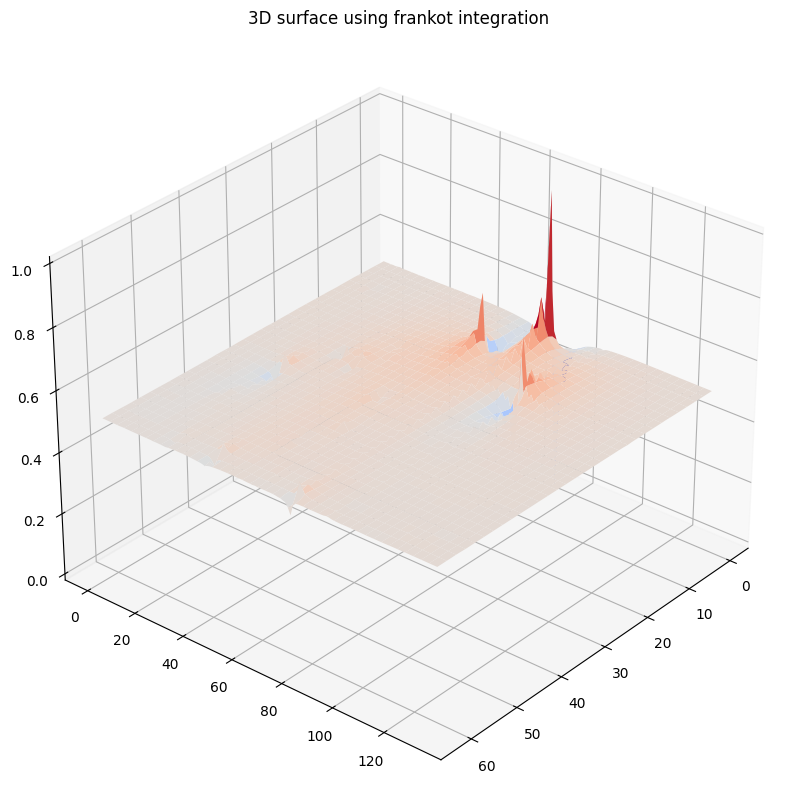

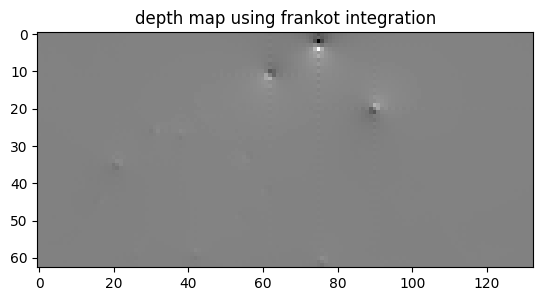

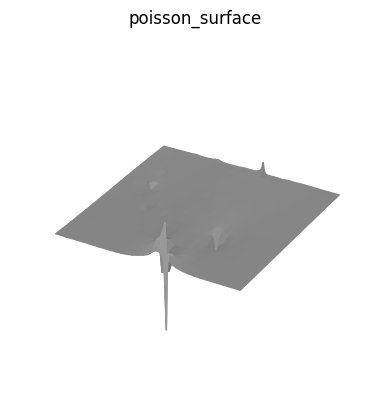

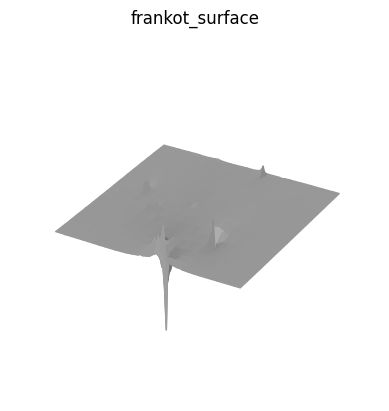

In [395]:
poisson_surface = normal_integration(Ne_optimized, img_shape, 0)
frankot_surface = normal_integration(Ne_optimized, img_shape, 1)

display_surface(poisson_surface, "poisson_surface")
display_surface(frankot_surface, "frankot_surface")

Rendering with a new light condition


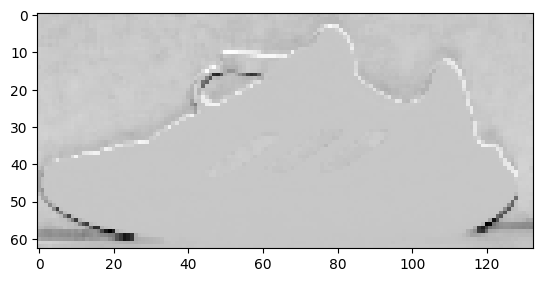

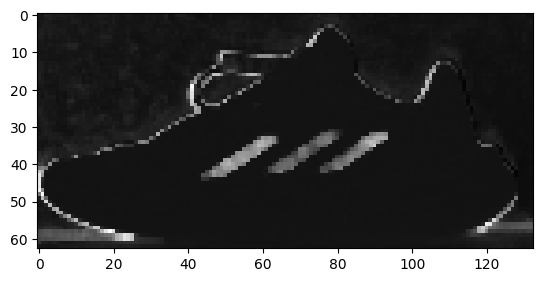

In [489]:
L_select = Le[:, 2]
ndotl = np.dot(Ne_optimized_img, L_select)
rad_field = Ae_optimized_img * ndotl
plt.imshow(rad_field, cmap='gray')
plt.show()

L_select = np.array([-1,-2,10]) 
L_select = L_select / np.linalg.norm(L_select)
ndotl = np.dot(Ne_optimized_img, L_select)
rad_field = Ae_optimized_img * ndotl
plt.imshow(rad_field, cmap='gray')
plt.show()